In [1]:
%pwd

'C:\\chemweb_project\\mysite\\predictor'

In [29]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # 3D 그래프용

from rdkit import Chem
from rdkit.Chem import Descriptors
import joblib

BASE_DIR   = r"C:\chemweb_project\mysite\predictor"
MODEL_PATH = os.path.join(BASE_DIR, "model.pkl")
SCALER_PATH = os.path.join(BASE_DIR, "scaler.pkl")
META_PATH   = os.path.join(BASE_DIR, "meta.pkl")

In [30]:
_model = None
_scaler = None
_input_columns = None

def load_artifacts():
    """model, scaler, input_columns를 한 번만 로딩해서 재사용"""
    global _model, _scaler, _input_columns

    if _model is not None:
        return _model, _scaler, _input_columns

    model = joblib.load(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    meta = joblib.load(META_PATH)

    input_columns = meta["input_columns"]

    _model = model
    _scaler = scaler
    _input_columns = input_columns

    print("[INFO] artifacts loaded. #features:", len(input_columns))

    return _model, _scaler, _input_columns

model, scaler, input_columns = load_artifacts()
len(input_columns), input_columns[:5]


[INFO] artifacts loaded. #features: 33


(33, ['Lecithin(%)', 'pH', 'DMSO_Conc (w/v%)', 'PEOE_VSA1', 'PEOE_VSA2'])

In [31]:
DESCRIPTOR_NAMES = (
    [f'PEOE_VSA{i}' for i in range(1, 8)] +
    [f'SlogP_VSA{i}' for i in range(1, 8)] +
    [f'SMR_VSA{i}' for i in range(1, 7)] +
    [f'AUTOCORR2D_{i}' for i in range(1, 7)] +
    ['BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
)

def calc_descriptors_for_smiles(smiles: str):
    """주어진 SMILES에 대한 분자 디스크립터 벡터 계산"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"[경고] RDKit이 SMILES를 해석하지 못했습니다: {smiles}")
        return [0.0] * len(DESCRIPTOR_NAMES)

    values = []
    for name in DESCRIPTOR_NAMES:
        try:
            func = getattr(Descriptors, name)
            values.append(func(mol))
        except Exception as e:
            print(f"[경고] 디스크립터 계산 실패: {name}, 에러: {e}")
            values.append(0.0)
    return values

In [4]:
test_desc = calc_descriptors_for_smiles("CCO")  # 에탄올 예시
len(test_desc), test_desc[:5]

(30, [5.106527394840706, 0.0, 0.0, 0.0, 0.0])

In [32]:
# 조건 변수 범위 (학습 데이터 기준)
LEC_MIN, LEC_MAX   = 1.0, 20.0      # Lecithin (%)
PH_MIN, PH_MAX     = 5.5, 7.4       # pH
DMSO_MIN, DMSO_MAX = 0.5, 10.0      # DMSO (w/v%)

# 훈련 때 썼던 컬럼 이름과 정확히 맞춰줘야 함!
COND_COLS = {
    "lec":  "Lecithin(%)",
    "ph":   "pH",
    "dmso": "DMSO_Conc (w/v%)",
}


In [33]:
def get_surface_for_smiles(
    smiles: str,
    fixed_var: str = "dmso",    # "dmso" / "lec" / "ph"
    fixed_value: float = 0.5,
    num_points: int = 30,
):
    """
    SMILES는 고정, fixed_var를 고정변수로 두고
    나머지 둘을 축으로 사용하는 3D surface용 데이터 생성
    """

    fixed_var = fixed_var.lower()
    if fixed_var not in ("dmso", "lec", "ph"):
        raise ValueError("fixed_var는 'dmso', 'lec', 'ph' 중 하나여야 합니다.")

    model, scaler, input_columns = load_artifacts()

    # --- 1) 각 변수 범위 설정 ---
    lec_range  = np.linspace(LEC_MIN,  LEC_MAX,  num_points)
    ph_range   = np.linspace(PH_MIN,   PH_MAX,   num_points)
    dmso_range = np.linspace(DMSO_MIN, DMSO_MAX, num_points)

    # --- 2) X, Y 축 선택 및 label ----
    if fixed_var == "dmso":
        # DMSO를 고정 → Lec vs pH
        X_vals = lec_range
        Y_vals = ph_range
        x_label = "Lecithin (%)"
        y_label = "pH"
    elif fixed_var == "lec":
        # Lec를 고정 → DMSO vs pH
        X_vals = dmso_range
        Y_vals = ph_range
        x_label = "DMSO_Conc (w/v%)"
        y_label = "pH"
    else:  # fixed_var == "ph"
        # pH를 고정 → DMSO vs Lec
        X_vals = dmso_range
        Y_vals = lec_range
        x_label = "DMSO_Conc (w/v%)"
        y_label = "Lecithin (%)"

    # --- 3) 2D 그리드 만들기 ---
    X_mesh, Y_mesh = np.meshgrid(X_vals, Y_vals)
    N = X_mesh.size  # 전체 포인트 수 = num_points^2

    # --- 4) 각 grid 포인트에서 lec/ph/dmso 값 만들기 ---
    if fixed_var == "dmso":
        lec_flat  = X_mesh.ravel()
        ph_flat   = Y_mesh.ravel()
        dmso_flat = np.full(N, fixed_value)
    elif fixed_var == "lec":
        dmso_flat = X_mesh.ravel()
        ph_flat   = Y_mesh.ravel()
        lec_flat  = np.full(N, fixed_value)
    else:  # fixed_var == "ph"
        dmso_flat = X_mesh.ravel()
        lec_flat  = Y_mesh.ravel()
        ph_flat   = np.full(N, fixed_value)

    # --- 5) SMILES 디스크립터는 한 번만 계산해서 복제 ---
    desc_values = calc_descriptors_for_smiles(smiles)
    desc_df = pd.DataFrame([desc_values] * N, columns=DESCRIPTOR_NAMES)

    # --- 6) 조건 변수 DataFrame (컬럼 이름 중요!) ---
    cond_df = pd.DataFrame({
        COND_COLS["lec"]:  lec_flat,
        COND_COLS["ph"]:   ph_flat,
        COND_COLS["dmso"]: dmso_flat,
    })

    # --- 7) full_df를 모델 입력 형식으로 맞추기 ---
    full_df = pd.concat([cond_df, desc_df], axis=1)
    full_df = full_df.reindex(columns=input_columns)

    # --- 8) 스케일링 + 예측 ---
    X_scaled = scaler.transform(full_df)
    X_scaled = pd.DataFrame(X_scaled, columns=input_columns)
    preds = model.predict(X_scaled)

    # --- 9) 2D 격자로 reshape ---
    Z = preds.reshape(X_mesh.shape)

    return X_mesh, Y_mesh, Z, x_label, y_label

In [7]:
def plot_surface_for_smiles(
    smiles: str,
    fixed_var: str = "dmso",
    fixed_value: float = 0.5,
    num_points: int = 30,
):
    X, Y, Z, x_label, y_label = get_surface_for_smiles(
        smiles=smiles,
        fixed_var=fixed_var,
        fixed_value=fixed_value,
        num_points=num_points,
    )

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X, Y, Z, cmap="viridis")

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel("Predicted logPe")

    if fixed_var == "dmso":
        title = f"logPe surface (fixed DMSO={fixed_value:.2f}%)"
    elif fixed_var == "lec":
        title = f"logPe surface (fixed Lecithin={fixed_value:.2f}%)"
    else:
        title = f"logPe surface (fixed pH={fixed_value:.2f})"

    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=10, label="logPe")

    plt.show()

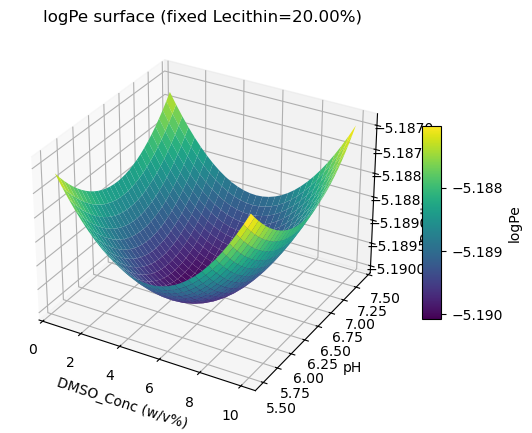

In [8]:
smiles = "CCO"  # 먼저 간단한 테스트용, 나중에 네 실제 SMILES로 바꾸면 됨

plot_surface_for_smiles(
    smiles=smiles,
    fixed_var="lec",   # 사용자가 고정할 변수
    fixed_value=20,    # 사용자가 고정 값
    num_points=30,
)

In [9]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, HBox, VBox, Output
from IPython.display import display, clear_output


In [10]:
def interactive_surface_for_smiles(smiles: str):
    """
    - SMILES는 고정
    - 사용자가:
        * 고정 변수(dmso / lec / ph) 선택
        * 고정값을 슬라이더로 조절
        * grid 해상도 조절
      → 할 때마다 3D 그래프를 다시 그려주는 UI
    """

    # 1) 위젯 정의
    fixed_dropdown = Dropdown(
        options=[
            ("DMSO 고정", "dmso"),
            ("Lecithin 고정", "lec"),
            ("pH 고정", "ph"),
        ],
        value="dmso",
        description="고정 변수:",
    )

    fixed_slider = FloatSlider(
        description="고정값:",
        continuous_update=False,  # 드래그 끝났을 때만 업데이트
    )

    grid_slider = IntSlider(
        value=30,
        min=15,
        max=50,
        step=5,
        description="grid:",
        continuous_update=False,
    )

    out = Output()

    # 2) 고정 변수 종류에 따라 슬라이더 범위/step 조정
    def update_slider_range(*args):
        var = fixed_dropdown.value

        if var == "dmso":
            fixed_slider.min = DMSO_MIN
            fixed_slider.max = DMSO_MAX
            fixed_slider.step = 0.5
            # 현재 값이 범위 밖이면 가운데 값으로 맞추기
            if not (DMSO_MIN <= fixed_slider.value <= DMSO_MAX):
                fixed_slider.value = (DMSO_MIN + DMSO_MAX) / 2

        elif var == "lec":
            fixed_slider.min = LEC_MIN
            fixed_slider.max = LEC_MAX
            fixed_slider.step = 1.0
            if not (LEC_MIN <= fixed_slider.value <= LEC_MAX):
                fixed_slider.value = (LEC_MIN + LEC_MAX) / 2

        else:  # "ph"
            fixed_slider.min = PH_MIN
            fixed_slider.max = PH_MAX
            fixed_slider.step = 0.1
            if not (PH_MIN <= fixed_slider.value <= PH_MAX):
                fixed_slider.value = (PH_MIN + PH_MAX) / 2

    # 3) 그래프 다시 그리는 함수
    def update_plot(*args):
        var = fixed_dropdown.value
        val = fixed_slider.value
        num_points = grid_slider.value

        with out:
            clear_output(wait=True)
            plot_surface_for_smiles(
                smiles=smiles,
                fixed_var=var,
                fixed_value=val,
                num_points=num_points,
            )

    # 4) 위젯 이벤트 연결
    fixed_dropdown.observe(update_slider_range, names="value")
    fixed_dropdown.observe(update_plot, names="value")
    fixed_slider.observe(update_plot, names="value")
    grid_slider.observe(update_plot, names="value")

    # 5) 처음 한 번 범위 세팅 + 초기 그래프
    update_slider_range()
    update_plot()

    # 6) 화면에 UI 보여주기
    ui = VBox([
        HBox([fixed_dropdown, fixed_slider, grid_slider]),
        out
    ])
    display(ui)


In [11]:
smiles = "C1=CC(=CC=C1[C@H]([C@@H](CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]"   # 먼저 테스트용 SMILES, 나중에 네 실제 SMILES로 바꿔도 됨

interactive_surface_for_smiles(smiles)

In [12]:
import plotly.graph_objects as go
import os

def make_plotly_surface_for_smiles(
    smiles: str,
    fixed_var: str = "dmso",
    fixed_value: float = 3.0,
    num_points: int = 30,
):
    # 기존 계산 함수 그대로 사용
    X, Y, Z, x_label, y_label = get_surface_for_smiles(
        smiles=smiles,
        fixed_var=fixed_var,
        fixed_value=fixed_value,
        num_points=num_points,
    )

    fig = go.Figure(
        data=[
            go.Surface(
                x=X,
                y=Y,
                z=Z,
                colorbar=dict(title="logPe"),
            )
        ]
    )

    if fixed_var == "dmso":
        title = f"logPe surface (fixed DMSO={fixed_value:.2f}%)"
    elif fixed_var == "lec":
        title = f"logPe surface (fixed Lecithin={fixed_value:.2f}%)"
    else:
        title = f"logPe surface (fixed pH={fixed_value:.2f})"

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title="Predicted logPe",
        ),
    )

    return fig


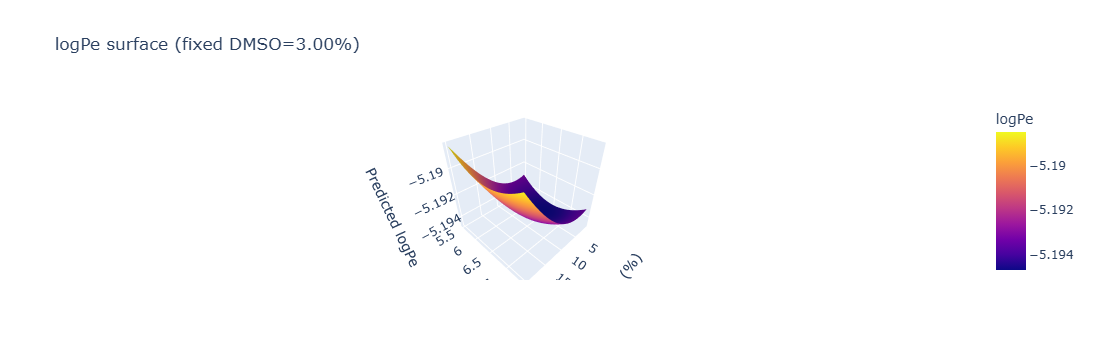

In [13]:
smiles = "CCO"  # 먼저 테스트용, 나중에 너의 실제 SMILES 넣으면 됨

fig = make_plotly_surface_for_smiles(
    smiles=smiles,
    fixed_var="dmso",
    fixed_value=3.0,
    num_points=30,
)
fig.show()


In [14]:
# static 파일이 저장될 위치
static_dir = os.path.join(BASE_DIR, "static", "predictor", "plots")
os.makedirs(static_dir, exist_ok=True)

output_path = os.path.join(static_dir, "logpe_3d.html")

smiles = "CCO"  # 또는 실제 SMILES

fig = make_plotly_surface_for_smiles(
    smiles=smiles,
    fixed_var="dmso",
    fixed_value=3.0,
    num_points=30,
)

fig.write_html(output_path, include_plotlyjs="cdn")

output_path


'C:\\chemweb_project\\mysite\\predictor\\static\\predictor\\plots\\logpe_3d.html'

In [15]:
import plotly.graph_objects as go
import numpy as np

def make_plotly_surface_with_dmso_slider(
    smiles: str,
    dmso_values=None,
    num_points: int = 25,
):
    """
    - x축: Lecithin (%)
    - y축: pH
    - z축: Predicted logPe
    - 슬라이더: DMSO (%)

    dmso_values: 슬라이더에 사용할 DMSO 값 리스트 (None이면 자동 생성)
    """

    if dmso_values is None:
        # DMSO 범위 전체를 적당한 간격으로 쪼개기 (예: 0.5 ~ 10.0 사이 8개)
        dmso_values = np.linspace(DMSO_MIN, DMSO_MAX, 8)

    dmso_values = list(dmso_values)

    # 1) 첫 번째 DMSO 값으로 초기 surface 생성
    first_dmso = dmso_values[0]
    X, Y, Z0, x_label, y_label = get_surface_for_smiles(
        smiles=smiles,
        fixed_var="dmso",
        fixed_value=first_dmso,
        num_points=num_points,
    )

    fig = go.Figure()

    # 초기 surface (colorbar는 여기서만)
    fig.add_trace(
        go.Surface(
            x=X,
            y=Y,
            z=Z0,
            colorbar=dict(title="logPe"),
        )
    )

    # 2) 각 DMSO 값마다 frame 생성
    frames = []
    for dmso in dmso_values:
        # 동일한 X, Y에 대해 Z만 바꿔서 계산
        _, _, Z, _, _ = get_surface_for_smiles(
            smiles=smiles,
            fixed_var="dmso",
            fixed_value=dmso,
            num_points=num_points,
        )
        frames.append(
            go.Frame(
                data=[
                    go.Surface(
                        x=X,
                        y=Y,
                        z=Z,
                        showscale=False,  # colorbar는 앞에서만
                    )
                ],
                name=f"{dmso:.2f}",
            )
        )

    fig.frames = frames

    # 3) 슬라이더 설정
    sliders = [
        {
            "active": 0,
            "pad": {"t": 50},
            "currentvalue": {"prefix": "DMSO (%): "},
            "steps": [
                {
                    "label": f"{dmso:.2f}",
                    "method": "animate",
                    "args": [
                        [f"{dmso:.2f}"],
                        {
                            "mode": "immediate",
                            "frame": {"duration": 0, "redraw": True},
                            "transition": {"duration": 0},
                        },
                    ],
                }
                for dmso in dmso_values
            ],
        }
    ]

    # 4) 재생/정지 버튼 (플레이하면 DMSO가 자동으로 변화)
    updatemenus = [
        {
            "type": "buttons",
            "showactive": False,
            "y": 0,
            "x": 1.05,
            "xanchor": "right",
            "yanchor": "top",
            "pad": {"t": 0, "r": 10},
            "buttons": [
                {
                    "label": "▶ Play",
                    "method": "animate",
                    "args": [
                        None,
                        {
                            "frame": {"duration": 500, "redraw": True},
                            "fromcurrent": True,
                        },
                    ],
                },
                {
                    "label": "⏸ Pause",
                    "method": "animate",
                    "args": [
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                        },
                    ],
                },
            ],
        }
    ]

    # 5) 레이아웃 설정
    fig.update_layout(
        title="logPe 3D Surface (Lec vs pH, DMSO 슬라이더)",
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title="Predicted logPe",
        ),
        sliders=sliders,
        updatemenus=updatemenus,
    )

    return fig


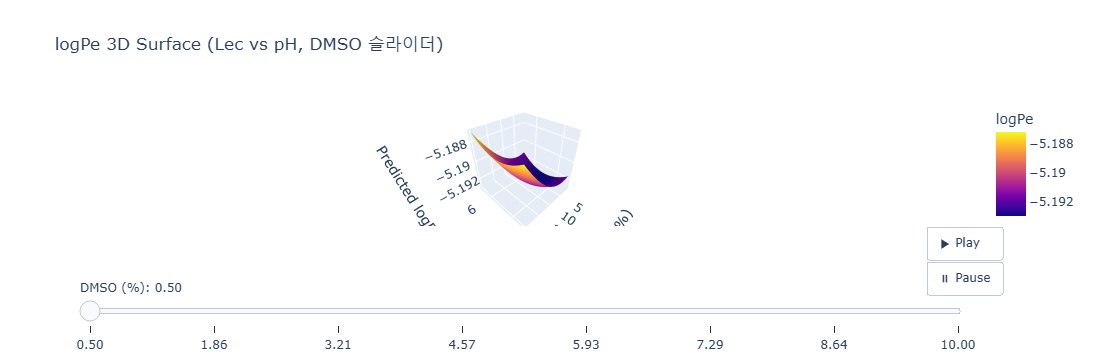

In [16]:
smiles = "CCO"  # 여기 나중에 네 실제 SMILES로 교체하면 됨

fig = make_plotly_surface_with_dmso_slider(
    smiles=smiles,
    num_points=25,     # 25 정도면 속도/퀄리티 적당
)
fig.show()


In [17]:
# static 파일 저장 경로 (이전에 썼던 것과 동일)
static_dir = os.path.join(BASE_DIR, "static", "predictor", "plots")
os.makedirs(static_dir, exist_ok=True)

output_path = os.path.join(static_dir, "logpe_3d.html")  # 기존과 동일 이름

smiles = "CCO"  # 또는 실제로 서비스에서 보여주고 싶은 SMILES

fig = make_plotly_surface_with_dmso_slider(
    smiles=smiles,
    num_points=25,
)

fig.write_html(output_path, include_plotlyjs="cdn")

output_path


'C:\\chemweb_project\\mysite\\predictor\\static\\predictor\\plots\\logpe_3d.html'

In [34]:
import plotly.graph_objects as go
import numpy as np

def make_plotly_surface_with_slider(
    smiles: str,
    fixed_var: str = "dmso",   # "dmso", "lec", "ph"
    num_points: int = 25,
    n_steps: int = 10,         # 슬라이더 단계 수
):
    """
    fixed_var:
        - "dmso":  x=Lec, y=pH,   슬라이더 = DMSO
        - "lec":   x=DMSO, y=pH,  슬라이더 = Lec
        - "ph":    x=DMSO, y=Lec, 슬라이더 = pH
    """

    fixed_var = fixed_var.lower()
    if fixed_var not in ("dmso", "lec", "ph"):
        raise ValueError("fixed_var는 'dmso', 'lec', 'ph' 중 하나여야 합니다.")

    # 고정 변수별로 슬라이더 값 범위 지정
    if fixed_var == "dmso":
        slider_label = "DMSO (%)"
        slider_values = np.linspace(DMSO_MIN, DMSO_MAX, n_steps)
    elif fixed_var == "lec":
        slider_label = "Lecithin (%)"
        slider_values = np.linspace(LEC_MIN, LEC_MAX, n_steps)
    else:  # "ph"
        slider_label = "pH"
        slider_values = np.linspace(PH_MIN, PH_MAX, n_steps)

    slider_values = list(slider_values)
    print("[DEBUG] slider_values:", slider_values, "개수:", len(slider_values))

    # 초기값
    first_val = slider_values[0]
    X, Y, Z0, x_label, y_label = get_surface_for_smiles(
        smiles=smiles,
        fixed_var=fixed_var,
        fixed_value=first_val,
        num_points=num_points,
    )

    fig = go.Figure()

    # 초기 surface (색상 포함)
    fig.add_trace(
        go.Surface(
            x=X,
            y=Y,
            z=Z0,
            colorscale="Inferno",          # ★ 높을수록 밝게, 낮을수록 어둡게
            colorbar=dict(title="logPe"),
        )
    )

    # frames 생성
    frames = []
    for v in slider_values:
        _, _, Z, _, _ = get_surface_for_smiles(
            smiles=smiles,
            fixed_var=fixed_var,
            fixed_value=v,
            num_points=num_points,
        )
        frames.append(
            go.Frame(
                data=[
                    go.Surface(
                        x=X,
                        y=Y,
                        z=Z,
                        showscale=False,
                        colorscale="Inferno",  # ★ 동일 컬러스케일
                    )
                ],
                name=f"{v:.3f}",  # 이름은 슬라이더와 매칭용
            )
        )

    fig.frames = frames
    print("[DEBUG] frames 개수:", len(fig.frames))

    # 슬라이더
    sliders = [
        {
            "active": 0,
            "pad": {"t": 50},
            "currentvalue": {"prefix": f"{slider_label}: "},
            "steps": [
                {
                    "label": f"{v:.3f}",
                    "method": "animate",
                    "args": [
                        [f"{v:.3f}"],
                        {
                            "mode": "immediate",
                            "frame": {"duration": 0, "redraw": True},
                            "transition": {"duration": 0},
                        },
                    ],
                }
                for v in slider_values
            ],
        }
    ]

    fig.update_layout(
        title=f"logPe 3D Surface (fixed {slider_label})",
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title="Predicted logPe",
        ),
        sliders=sliders,
    )

    return fig



In [35]:
# static 경로 준비
static_dir = os.path.join(BASE_DIR, "static", "predictor", "plots")
os.makedirs(static_dir, exist_ok=True)

smiles = "CCO"  # 또는 서비스에서 쓸 실제 SMILES

# 1) DMSO 고정 슬라이더
fig_dmso = make_plotly_surface_with_slider(
    smiles=smiles,
    fixed_var="dmso",
    num_points=25,
    n_steps=10,
)
path_dmso = os.path.join(static_dir, "logpe_dmso_v2.html")
fig_dmso.write_html(path_dmso, include_plotlyjs="cdn")

# 2) Lecithin 고정 슬라이더
fig_lec = make_plotly_surface_with_slider(
    smiles=smiles,
    fixed_var="lec",
    num_points=25,
    n_steps=10,
)
path_lec = os.path.join(static_dir, "logpe_lec_v2.html")
fig_lec.write_html(path_lec, include_plotlyjs="cdn")

# 3) pH 고정 슬라이더
fig_ph = make_plotly_surface_with_slider(
    smiles=smiles,
    fixed_var="ph",
    num_points=25,
    n_steps=10,
)
path_ph = os.path.join(static_dir, "logpe_ph.html")
fig_ph.write_html(path_ph, include_plotlyjs="cdn")

path_dmso, path_lec, path_ph


[DEBUG] slider_values: [np.float64(0.5), np.float64(1.5555555555555556), np.float64(2.611111111111111), np.float64(3.666666666666667), np.float64(4.722222222222222), np.float64(5.777777777777778), np.float64(6.833333333333334), np.float64(7.888888888888889), np.float64(8.944444444444445), np.float64(10.0)] 개수: 10
[DEBUG] frames 개수: 10
[DEBUG] slider_values: [np.float64(1.0), np.float64(3.111111111111111), np.float64(5.222222222222222), np.float64(7.333333333333334), np.float64(9.444444444444445), np.float64(11.555555555555555), np.float64(13.666666666666668), np.float64(15.777777777777779), np.float64(17.88888888888889), np.float64(20.0)] 개수: 10
[DEBUG] frames 개수: 10
[DEBUG] slider_values: [np.float64(5.5), np.float64(5.711111111111111), np.float64(5.9222222222222225), np.float64(6.133333333333334), np.float64(6.344444444444445), np.float64(6.555555555555555), np.float64(6.766666666666667), np.float64(6.977777777777778), np.float64(7.188888888888889), np.float64(7.4)] 개수: 10
[DEBUG] fr

('C:\\chemweb_project\\mysite\\predictor\\static\\predictor\\plots\\logpe_dmso.html',
 'C:\\chemweb_project\\mysite\\predictor\\static\\predictor\\plots\\logpe_lec.html',
 'C:\\chemweb_project\\mysite\\predictor\\static\\predictor\\plots\\logpe_ph.html')